In [53]:
pip install contextily --quiet

Note: you may need to restart the kernel to use updated packages.


In [144]:
pip install piecewise_regression --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import rasterstats
from rasterstats import zonal_stats
import rasterio
import rioxarray as rxr
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import piecewise_regression as pwr

In [2]:
spatial_path = "/Users/markos98/aquasteady_research/data/spatial/"
shape_path = "/Users/markos98/aquasteady_research/data/spatial/ca_counties/"
raw_path = "/Users/markos98/aquasteady_research/data/raw/"
transformed_path = "/Users/markos98/aquasteady_research/data/transformed/"

In [3]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_data = src.read(1)  
    bounds = src.bounds     
    crs = src.crs

In [5]:
counties = gpd.read_file(shape_path + "CA_Counties.shp")
counties = counties.to_crs(crs)  # Match CRS to SPI data

In [6]:
convex_hull = counties[['geometry']].dissolve().convex_hull

In [7]:
convex_hull = gpd.GeoDataFrame(geometry=convex_hull)

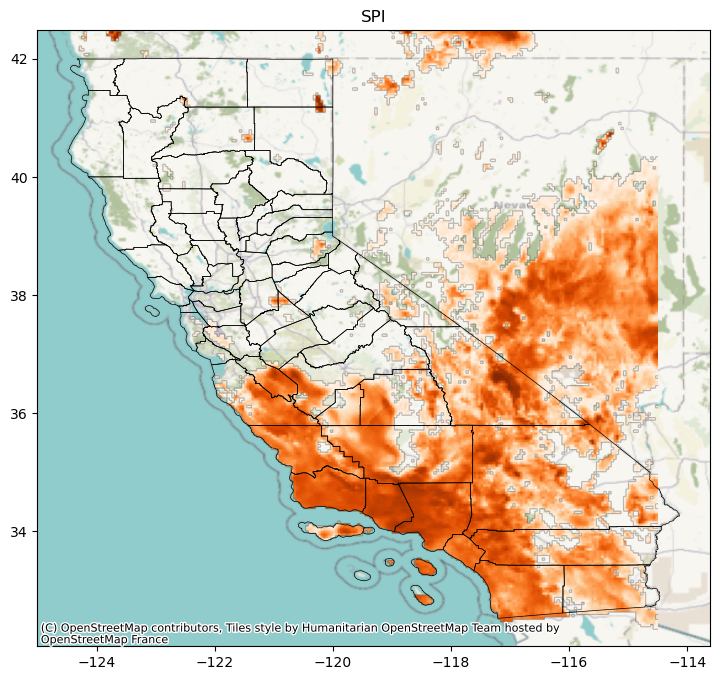

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

# Overlay watershed boundaries
counties.boundary.plot(ax=ax, linewidth=0.5, color="black")

# convex_hull.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, linestyle='--', label='Convex Hull')

# basemap = cx.providers.Stadia.TerrainBackground

cx.add_basemap(ax, crs = counties.crs.to_string())

show(spi_data, ax=ax, transform=src.transform, cmap="Oranges", alpha=1.0)

# Add USDA irrigation data (if available)
# Example: Color watersheds by irrigation acres
# CA_watersheds.plot(ax=ax, column="Irrigated_Acres", legend=True, alpha=0.3)

plt.title("SPI")
plt.show()

In [9]:
with rasterio.open(spatial_path + "california.tif") as src:
    spi_array = src.read(1)  # NumPy array
    affine_transform = src.transform  # Affine transform

In [10]:
spi_stats = rasterstats.zonal_stats(
    counties, 
    spi_array,
    affine=affine_transform,
    stats=["mean"], 
    geojson_out=True
)

/Volumes/Mac/opt/anaconda3/envs/aquasteady/lib/python3.13/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [11]:
spi = gpd.GeoDataFrame.from_features(spi_stats)

In [10]:
print("SPI FP:", spi["STATEFP"].unique())

SPI HUC6: ['180600' '180800' '180703' '180101' '180701' '180901' '180500' '180200'
 '180702' '181002' '180400' '180102' '180201' '180300' '180902' '181001']


In [60]:
usda = pd.read_csv(transformed_path + "usda.csv")

In [61]:
spi['huc6'] = spi['huc6'].astype(np.int64)

In [62]:
usda['huc6'] = usda['huc6'].astype(np.int64)

In [63]:
merged = usda.merge(
    spi, 
    on="huc6",     
    how="left"     
)

print(f"Merged rows: {len(merged)}") 

Merged rows: 32


In [64]:
merged.rename(columns={'Cropland on which all crops failed or were abandoned': 
                     'total_crop_failure'}, inplace=True)

In [65]:
merged = merged.dropna(subset=["mean"])

In [66]:
merged = merged.dropna(subset=["total_crop_failure"])

In [67]:
merged.head()

,huc6,Year,Land in farms,Total cropland,Harvested cropland,Other pasture and grazing land that could have been used for crops without additional improvement,Cropland idle or used for cover crops or soil-improvement but not harvested and not pastured or grazed,total_crop_failure,Cropland in summer fallow,Total woodland,...,loaddate,referenceg,areaacres,areasqkm,states,name,shape_Leng,shape_Area,ObjectID,mean
2,180102,2022,1216990,333751,234108,28496,39737,16691,14719,152675,...,2024-08-16,277534,10040760.31,40633.55,"CA,OR",Klamath,None,None,12,0.314958
3,180102,2017,1260192,305822,222976,31241,30939,8883,11783,197476,...,2024-08-16,277534,10040760.31,40633.55,"CA,OR",Klamath,None,None,12,0.314958
4,180200,2022,790413,165638,111711,25455,21010,2845,4617,78174,...,2024-08-16,1654949,4914813.15,19889.56,"CA,OR",Upper Sacramento,None,None,8,1.021672
5,180200,2017,909381,161700,122278,16675,9082,5099,8566,84576,...,2024-08-16,1654949,4914813.15,19889.56,"CA,OR",Upper Sacramento,None,None,8,1.021672
6,180201,2022,3956840,1685465,1242597,67056,149953,65767,160092,285743,...,2024-08-16,1654949,12880011.17,52123.60,CA,Lower Sacramento,None,None,13,0.316029


In [75]:
merged.to_csv('merged.csv', index=True)

In [68]:
formula = "mean ~ total_crop_failure"

In [69]:
model = smf.ols(formula, data=merged).fit()

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     4.050
Date:                Mon, 12 May 2025   Prob (F-statistic):              0.137
Time:                        11:34:32   Log-Likelihood:                 36.466
No. Observations:                  30   AIC:                            -18.93
Df Residuals:                       3   BIC:                             18.90
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.7584      0.113      6.684      0.007       0.397       1.119
total_crop_failure[T.-]        -0.2811      0.254     -1.108      0.349      -1.088       0.526
total_crop_failure[T.13351]     0.4762      0.254      1.877      0.157      -0.331       1.284
total_crop_failure[T.13554]    -0.2947      0.254     -1.162      0.329      -1.102       0.513
total_crop_failure[T.14574]     0.4762      0.254      1.877      0.157      -0.331       1.284
total_crop_failure[T.16691]    -0.4434      0.254     -1.748      0.179      -1.251       0.364
total_crop_failure[T.1835]      0.6827      0.254      2.691      0.074      -0.125       1.490
total_crop_failure[T.19250]    -0.0061      0.254     -0.024      0.982      -0.813       0.801
total_crop_failure[T.2405]      0.9111      0.254      3.591      0.037       0.104       1.718
total_crop_failure[T.26411]    -0.0061      0.254     -0.024      0.982      -0.813       0.801
total_crop_failure[T.2743]      0.9111      0.254      3.591      0.037       0.104       1.718
total_crop_failure[T.2828]     -0.5976      0.254     -2.356      0.100      -1.405       0.210
total_crop_failure[T.2845]      0.2633      0.254      1.038      0.376      -0.544       1.071
total_crop_failure[T.28973]    -0.4424      0.254     -1.744      0.180      -1.250       0.365
total_crop_failure[T.3079]     -0.5976      0.254     -2.356      0.100      -1.405       0.210
total_crop_failure[T.3424]      0.6827      0.254      2.691      0.074      -0.125       1.490
total_crop_failure[T.41691]     0.0747      0.254      0.294      0.788      -0.733       0.882
total_crop_failure[T.4261]      0.5419      0.254      2.136      0.122      -0.265       1.349
total_crop_failure[T.4759]      0.5419      0.254      2.136      0.122      -0.265       1.349
total_crop_failure[T.5076]     -0.2947      0.254     -1.162      0.329      -1.102       0.513
total_crop_failure[T.5099]      0.2633      0.254      1.038      0.376      -0.544       1.071
total_crop_failure[T.5132]      0.0327      0.254      0.129      0.906      -0.775       0.840
total_crop_failure[T.52461]     0.0747      0.254      0.294      0.788      -0.733       0.882
total_crop_failure[T.61]        0.2747      0.254      1.083      0.358      -0.533       1.082
total_crop_failure[T.65767]    -0.4424      0.254     -1.744      0.180      -1.250       0.365
total_crop_failure[T.732]       0.0327      0.254      0.129      0.906      -0.775       0.840
total_crop_failure[T.8883]     -0.4434      0.254     -1.748      0.179      -1.251       0.364
==============================================================================
Omnibus:                       20.523   Durbin-Watson:                   2.999
Prob(Omnibus):                  0.000   Jarqu

In [54]:
huc2 = gpd.read_file(spatial_path + "huc2-basins.geojson")

In [55]:
print(huc2.head())

   objectid                                   tnmid metasourceid  \
0         1  {9F7DA17F-2AB2-4A27-B6AD-C3475BBA7C4A}         None   
1         2  {7721F096-C381-4519-85C2-2FE21109F869}         None   
2         3  {7271463E-B5E4-4017-8E10-24A186190541}         None   
3         4  {4C2998C0-D39C-47B3-8848-549D9184B95B}         None   
4         5  {5C6AE09C-4CFC-4EBA-9344-A91AF35E73E8}         None   

  sourcedatadesc sourceoriginator sourcefeatureid            loaddate  \
0           None             None            None 2021-06-27 08:35:53   
1           None             None            None 2019-12-05 11:32:03   
2           None             None            None 2016-10-11 16:37:03   
3           None             None            None 2020-02-05 11:05:50   
4           None             None            None 2021-02-01 10:10:42   

  referencegnis_ids     areaacres   areasqkm  \
0              None  1.172622e+08  474543.67   
1              None  3.846772e+06   15567.35   
2       

In [56]:
huc2 = huc2.to_crs(epsg=3857)

In [57]:
huc2 = huc2.drop([1, 17, 2])

In [58]:
random_forest = gpd.read_file(transformed_path + "random_forest.csv")

In [59]:
importances_by_region = huc2.merge(
    random_forest, 
    on="huc2",     
    how="left"     
)

print(f"Merged rows: {len(importances_by_region)}") 

Merged rows: 19


/var/folders/d7/s9v4vr012y797bmw4ryrcfgc0000gn/T/ipykernel_9026/1853512747.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


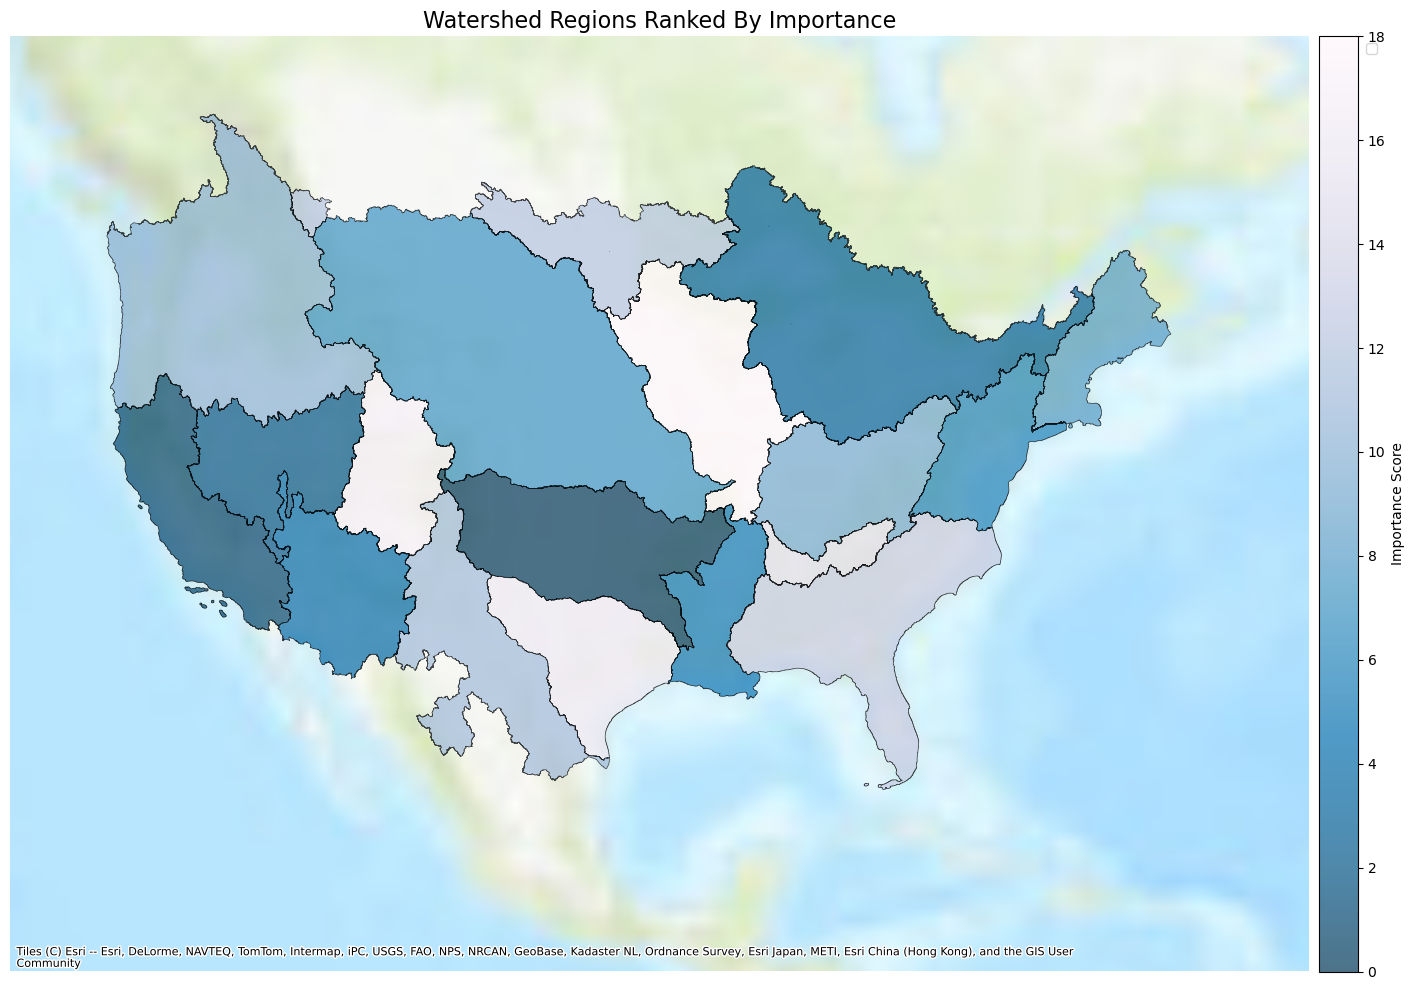

In [93]:
# Create a figure
fig, ax = plt.subplots(figsize=(15, 10))

# Plot watersheds (color by importance or another variable)
importances_by_region.plot(
    ax=ax,
    column="name",  # Replace with your target column (e.g., from random_forest.csv)
    cmap="PuBu_r",
    alpha=0.7,
    edgecolor="k",
    linewidth=0.5,
    legend=False
)

# Label specific regions (adjust names to match your GeoJSON)
regions_to_label = {
    "California": (-1.25e7, 4.0e6),  # Manual position override (optional)
    "Arkansas-White-Red": (-1.0e7, 3.5e6),
    "Missouri": (-1.1e7, 4.8e6)
}

for region_name, (x, y) in regions_to_label.items():
    region = huc2[huc2["name"] == region_name]  # Replace "name" with your GeoJSON's region column
    if not region.empty:
        # Use centroid or manual position
        ax.annotate(
            text=region_name.replace("-", "\n"),  # Split hyphenated names
            xy=(x, y),  # Use manual position or region.geometry.centroid.coords[0]
            ha="center",
            fontsize=10,
            color="black",
            weight="bold",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=2)
        )

# Add subtle colorbar for context (optional)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(ax.collections[0], cax=cax, label="Importance Score")

# Add basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)

# Widen horizontal scope (adjust xlim)
ax.set_xlim(-1.45e7, -6.5e6)  # Wider than before (-1.39e7, -7.35e6)
ax.set_ylim(1.68e6, 7.44e6)   # Keep vertical bounds

# Customize
ax.set_title("Watershed Regions Ranked By Importance", fontsize=16)
ax.set_axis_off()  # Hide axes for a clean map
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.savefig("watershed_map.png", dpi=300)  # Save high-res
plt.show()